# Подключение библиотеки

In [1]:
import os
import sys
import uuid
import numpy as np
import pandas as pd
import seaborn as sb
from tqdm.auto import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

from IPython.display import display, HTML, Markdown
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Импорт и анализ данных

In [2]:
try:
    df = pd.read_csv('Amp_C_train.txt')
except:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
            
    df = pd.read_csv(os.path.join(dirname, filename))

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172032 entries, 0 to 172031
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    172032 non-null  float64
 1   Input   172032 non-null  object 
 2   Output  172032 non-null  object 
dtypes: float64(1), object(2)
memory usage: 3.9+ MB


## Проверка наличия CUDA

In [4]:
# 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda':
    print("CUDA is available!")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA capability: {torch.cuda.get_device_capability(0)}")
    print(f"Driver version: {torch.version.cuda}")
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
else:
    print("CUDA is not available. Running on CPU.")

CUDA is available!
Device name: NVIDIA GeForce GTX 1650 Ti
CUDA capability: (7, 5)
Driver version: 12.1
Device count: 1
Current device: 0


## Создание нейросети

### Memory Polynomial (MP) модель

In [5]:
class MemoryPolynomialNNTrainer:
    def __init__(self, df, M, K, batch_size=64, learning_rate=0.001, epochs=10, hidden_layers=[64, 128], dropout_rate=0.5, l1_lambda=0.0, l2_lambda=0.0, patience=2, factor=0.9, edit_model=None, device=None):
        """
        Инициализация класса для тренировки модели Memory Polynomial с использованием нейронных сетей.

        Args:
            df (pd.DataFrame): Входные данные.
            M (int): Глубина памяти.
            K (int): Степень полинома.
            batch_size (int, optional): Размер батча для обучения. По умолчанию 64.
            learning_rate (float, optional): Скорость обучения для оптимизатора. По умолчанию 0.001.
            epochs (int, optional): Количество эпох. По умолчанию 10.
            hidden_layers (list, optional): Конфигурация скрытых слоев. По умолчанию [64, 128].
            device (str, optional): Устройство для выполнения вычислений ('cpu' или 'cuda'). По умолчанию None.
        """
        # Подготовка данных
        self.df = self.prepare_data(df)
        self.device = self.get_device(device)
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.M = M
        self.K = K
        self.hidden_layers = hidden_layers
        self.dropout_rate = dropout_rate
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda

        # История обучения
        self.history = {"epoch": [], "rmse": []}

        # Генерация уникального ID
        self.model_id = str(uuid.uuid4())

        # Подготовка данных
        X, y, self.times = self.create_dataset(self.df, M, K)
        self.dataset = TensorDataset(
            torch.tensor(X, dtype=torch.float32),
            torch.tensor(self.times, dtype=torch.float32),
            torch.tensor(y, dtype=torch.float32)
        )
        self.train_loader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True)

        # Инициализация модели
        if edit_model:
            self.model = edit_model(input_size=X.shape[1] + 1, hidden_layers=hidden_layers, output_size=2, dropout_rate=dropout_rate).to(self.device)
        else:
            self.model = self.DefaultSimpleMLP(input_size=X.shape[1] + 1, hidden_layers=hidden_layers, output_size=2, dropout_rate=dropout_rate).to(self.device) if not edit_model else edit_model
            
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', patience=patience, factor=factor)

    class DefaultSimpleMLP(nn.Module):
        def __init__(self, input_size, hidden_layers, output_size=2, dropout_rate=0.5):
            super().__init__()

            layers = []
            # Входной слой
            layers.append(nn.Linear(input_size, hidden_layers[0]))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_layers[0]))  # Batch Normalization
            layers.append(nn.Dropout(dropout_rate))

            # Скрытые слои
            for i in range(1, len(hidden_layers)):
                layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
                layers.append(nn.ReLU())
                layers.append(nn.BatchNorm1d(hidden_layers[i]))  # Batch Normalization
                layers.append(nn.Dropout(dropout_rate))

            # Выходной слой
            layers.append(nn.Linear(hidden_layers[-1], output_size))

            self.model = nn.Sequential(*layers)

        def forward(self, x):
            return self.model(x)
                
    @staticmethod
    def prepare_data(df):
        """
        Преобразование входных данных: разделение на реальные и мнимые части.

        Args:
            df (pd.DataFrame): Входные данные.

        Returns:
            pd.DataFrame: Обработанные данные.
        """
        df.columns = df.columns.str.lower()
        df['input'] = df['input'].apply(lambda x: complex(x))
        df['output'] = df['output'].apply(lambda x: complex(x))
        df['input_real'] = df['input'].apply(lambda x: x.real)
        df['input_imag'] = df['input'].apply(lambda x: x.imag)
        df['output_real'] = df['output'].apply(lambda x: x.real)
        df['output_imag'] = df['output'].apply(lambda x: x.imag)
        df = df.drop(['input', 'output'], axis=1)
        df = df.set_index('time')  # 'time' колонка теперь индекс
        return df

    @staticmethod
    def get_device(select=None):
        """
        Определение устройства для вычислений (CPU или GPU).

        Args:
            select (str, optional): Выбор устройства ('cpu', 'cuda'). По умолчанию None.

        Returns:
            torch.device: Устройство для вычислений.
        """
        if select is None or select == 'cuda':
            return torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        return torch.device('cpu')

    @staticmethod
    def create_dataset(df, M, K):
        """
        Создание обучающих данных на основе полиномиальной модели с памятью и добавлением времени.

        Args:
            df (pd.DataFrame): Обработанные данные.

        Returns:
            tuple: Матрица признаков X, объединенные целевые значения y и временные метки times.
        """
        x_real = df['input_real'].values
        x_imag = df['input_imag'].values
        y_real = df['output_real'].values[M:]
        y_imag = df['output_imag'].values[M:]
        times = df.index.values[M:]

        # Объединение реальных и мнимых частей в один целевой вектор
        y = np.stack([y_real, y_imag], axis=1)

        N = len(x_real)
        X = np.zeros((N, (M + 1) * K * 2), dtype=np.float64)
        for n in range(M, N):
            index = 0
            for m in range(M + 1):
                for k in range(1, K + 1):
                    X[n, index] = np.abs(x_real[n - m])**(k-1) * x_real[n - m]
                    X[n, index + 1] = np.abs(x_imag[n - m])**(k-1) * x_imag[n - m]
                    index += 2
        return X[M:], y, times

    def l1_l2_regularization(self):
        l1_norm = sum(p.abs().sum() for p in self.model.parameters())
        l2_norm = sum((p ** 2).sum() for p in self.model.parameters())
        return self.l1_lambda * l1_norm + self.l2_lambda * l2_norm

    def train(self, max_early_stopping_counter=5):
        """
        Обучение модели на объединенных целевых данных (реальная и мнимая части).
        """
        self.model.train()
        early_stopping_counter = 0
        best_rmse = float('inf')

        for epoch in range(self.epochs):
            total_rmse = 0
            progress_bar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{self.epochs}", unit="batch")

            for batch_idx, (X_batch, times_batch, y_batch) in enumerate(progress_bar):
                X_batch, times_batch, y_batch = X_batch.to(self.device), times_batch.to(self.device), y_batch.to(self.device)

                # Объединение временных меток с входными признаками
                X_with_times = torch.cat((X_batch, times_batch.unsqueeze(1)), dim=1)

                self.optimizer.zero_grad()
                pred = self.model(X_with_times)
                loss = self.criterion(pred, y_batch)
                rmse = torch.sqrt(loss)  # RMSE
                rmse.backward()
                self.optimizer.step()

                total_rmse += rmse.item()
                
                # Получение текущего значения learning rate
                current_learning_rate = self.optimizer.param_groups[0]['lr']

                progress_bar.set_postfix(rmse=f"{rmse:.10f}", lr=f"{current_learning_rate:.6f}")

            avg_rmse = total_rmse / len(self.train_loader)
            self.history["epoch"].append(epoch + 1)
            self.history["rmse"].append(avg_rmse)

            # Обновление learning rate scheduler
            self.scheduler.step(avg_rmse)
            
            # Early Stopping
            if avg_rmse < best_rmse:
                best_rmse = avg_rmse
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
            
            if early_stopping_counter >= max_early_stopping_counter:  # Параметр patience для Early Stopping
                print("Early stopping activated.")
                break
                
            print(f"Epoch {epoch+1}/{self.epochs}, RMSE: {avg_rmse:.6f}")

    def evaluate(self):
        """
        Оценка модели после обучения.
        
        Returns:
            float: Значение RMSE.
        """
        self.model.eval()
        all_preds = []
        all_true = []

        with torch.no_grad():
            for X_batch, times_batch, y_batch in self.train_loader:
                X_batch, times_batch, y_batch = X_batch.to(self.device), times_batch.to(self.device), y_batch.to(self.device)
                
                # Объединение временных меток с входными признаками
                X_with_times = torch.cat((X_batch, times_batch.unsqueeze(1)), dim=1)

                pred = self.model(X_with_times)
                
                all_preds.append(pred.cpu().numpy())
                all_true.append(y_batch.cpu().numpy())

        # Конкатенация всех предсказаний и истинных значений
        self.pred = np.concatenate(all_preds)
        self.true = np.concatenate(all_true)
        
        # Вычисление RMSE
        rmse = np.sqrt(mean_squared_error(self.true, self.pred))

        print(f"Evaluation RMSE: {rmse:.6f}")
        return rmse
        
    def save_model_pt(self, filename_prefix='node', save_dir='models'):
        """
        Сохраняет всю модель PyTorch в формате .pt.

        Args:
            filename_prefix (str, optional): Префикс имени файла. По умолчанию 'node'.
            save_dir (str, optional): Директория для сохранения модели. По умолчанию 'models'.
        """
        # Создаем папку, если ее нет
        os.makedirs(save_dir, exist_ok=True)

        # Генерируем имя файла с текущей датой и временем
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}_{self.model_id}.pt"

        # Полный путь к файлу
        filepath = os.path.join(save_dir, filename)

        # Сохраняем ВСЮ модель
        torch.save(self.model, filepath)
        print(f"Model saved in {filepath}")

    def plot_training_history(self, window_size=5):
        """
        Строит графики истории обучения модели, отображая RMSE на каждой эпохе и скользящее среднее.
        """
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
        # Преобразуем список эпох для оси X
        epochs = self.history["epoch"]
    
        # Вычисляем скользящее среднее
        rmse = np.array(self.history["rmse"])
        moving_avg = np.convolve(rmse, np.ones(window_size)/window_size, mode='valid')
    
        # Первый график: Полная история
        axs[0].plot(epochs, rmse, marker='o', linestyle='-', color='b', markersize=5, label='RMSE')
        axs[0].plot(epochs[window_size-1:], moving_avg, color='r', label=f'Moving Average (window size={window_size})')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Average Loss')
        axs[0].set_title('Loss Function (Full History)')
        axs[0].grid(True)
        axs[0].legend()
    
        # Второй график: Половина истории
        mid_index = len(epochs) // 2
        axs[1].plot(epochs[mid_index:], rmse[mid_index:], marker='o', linestyle='-', color='b', markersize=5, label='RMSE')
        axs[1].plot(epochs[mid_index + window_size - 1:], moving_avg[mid_index:], color='r', label=f'Moving Average (window size={window_size})')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Average RMSE')
        axs[1].set_title('Loss Function (Second Half of Training)')
        axs[1].grid(True)
        axs[1].legend()
    
        plt.tight_layout()
        plt.show()

    def plot_predictions(self, time_start=0, time_end=1.01e-4):
        """
        Построение графиков предсказанных и фактических значений в заданном временном диапазоне.

        Args:
            time_start (float, optional): Начальное время для отображения. По умолчанию 0.
            time_end (float, optional): Конечное время для отображения. По умолчанию 1.01e-4.
        """
        self.model.eval()
        pred_real, pred_imag = self.pred[:, 0], self.pred[:, 1]
        true_real, true_imag = self.true[:, 0], self.true[:, 1]

        # Фильтрация данных по указанному временному диапазону
        time_mask = (self.times >= time_start) & (self.times <= time_end)

        selected_times = self.times[time_mask]
        
        # Фильтрация предсказаний и фактических значений по временному диапазону
        pred_real = pred_real[time_mask]
        pred_imag = pred_imag[time_mask]
        true_real = true_real[time_mask]
        true_imag = true_imag[time_mask]
    
        # Проверка, чтобы убедиться, что данные не пустые
        if len(selected_times) == 0:
            print(f"No data points found between {time_start} and {time_end}.")
            return
        
        # Построение графиков
        fig, axs = plt.subplots(2, 1, figsize=(15, 8))

        # Реальная часть
        axs[0].plot(selected_times, true_real, label='True Real', linestyle='-', color='red')
        axs[0].plot(selected_times, pred_real, label='Predicted Real', linestyle='-', color='blue')
        axs[0].set_xlabel('Time')
        axs[0].set_ylabel('Real Part')
        axs[0].legend()
        axs[0].grid(True)

        # Мнимая часть
        axs[1].plot(selected_times, true_imag, label='True Imag', linestyle='-', color='red')
        axs[1].plot(selected_times, pred_imag, label='Predicted Imag', linestyle='-', color='blue')
        axs[1].set_xlabel('Time')
        axs[1].set_ylabel('Imaginary Part')
        axs[1].legend()
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

    def draw_plot_signal(self, signal_type, time_start=0, time_end=1e-6):
        """
        Построение графика сигнала в указанном временном диапазоне.
        
        Args:
            signal_type (str): Тип сигнала ('input' или 'output').
            time_start (float): Начальное время.
            time_end (float): Конечное время.
        """
        # Фильтрация данных по временной отметке
        filtered_data = self.df[(self.df.index >= time_start) & (self.df.index <= time_end)]
        time = filtered_data.index

        # Построение графика реальной и мнимой частей сигнала
        plt.figure(figsize=(10, 6))
        plt.plot(time, filtered_data[f'{signal_type}_real'], label=f'{signal_type} Real Part', color='blue', linestyle='-')
        plt.plot(time, filtered_data[f'{signal_type}_imag'], label=f'{signal_type} Imaginary Part', color='red', linestyle='-')
        
        plt.title(f'{signal_type.capitalize()} Signal from {time_start} to {time_end} seconds')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.show()

    def print_model_summary(self, filename_prefix="model_parameters", save_dir='history'):
        """
        Выводит информацию о модели и сохраняет её параметры и их размерности в CSV файл.

        Args:
            filename_prefix (str, optional): Префикс имени файла. По умолчанию 'model_parameters'.
            save_dir (str, optional): Директория для сохранения файла. По умолчанию 'history'.
        """
        # Создаем папку, если ее нет
        os.makedirs(save_dir, exist_ok=True)

        # Генерируем имя файла с текущей датой и временем
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}_{self.model_id}.csv"

        # Полный путь к файлу
        filepath = os.path.join(save_dir, filename)
        
        df_params = pd.DataFrame(columns=['Parameter name', 'Parameter shape', 'Parameter count'])
        
        print(f"Model architecture: {self.model}")
        print("-" * 50)

        total_params = 0
        for name, param in self.model.named_parameters():
            print(f"Parameter name: {name}")
            print(f"Parameter shape: {param.shape}")
            param_count = torch.numel(param)
            print(f"Parameter count: {param_count}")
            print("-" * 30)

            # Добавляем информацию о параметре в DataFrame
            df_params.loc[len(df_params)] = [name, param.shape, param_count] 
            
            total_params += param_count

        print(f"Total trainable parameters: {total_params}")
        print("=" * 50)
        
        # Сохраняем DataFrame в CSV файл
        df_params.to_csv(filepath, index=False)
        
        print(f"Print model saved in {filepath}")

### Кастомные модели

In [6]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size=2, dropout_rate=0.0):
        """
        Простая классическая нейросеть MLP для регрессии реальной и мнимой частей сигнала.

        Args:
            input_size (int): Размерность входного слоя (количество признаков).
            hidden_layers (list): Список размеров скрытых слоев.
            output_size (int, optional): Размерность выходного слоя. По умолчанию 2 (для реальной и мнимой части).
            dropout_rate (float, optional): Вероятность отключения нейронов. По умолчанию 0.0 (без отключения).
        """
        super().__init__()
        
        layers = []
        # Входной слой
        layers.append(nn.Linear(input_size, hidden_layers[0]))
        layers.append(nn.ReLU())
        if dropout_rate > 0:
            layers.append(nn.Dropout(dropout_rate))  # Добавляем Dropout

        # Скрытые слои
        for i in range(1, len(hidden_layers)):
            layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
            layers.append(nn.ReLU())
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))  # Добавляем Dropout

        # Выходной слой
        layers.append(nn.Linear(hidden_layers[-1], output_size))
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        """
        Прямой проход через MLP.
        Args:
            x (torch.Tensor): Входные данные.
        Returns:
            torch.Tensor: Прогнозы (реальная и мнимая части).
        """
        return self.model(x)

## Установка параметров

In [7]:
M = 5  # Глубина памяти
K = 7  # Степень полинома

In [8]:
batch_size=1024*5
learning_rate=1e-4
epochs=100
hidden_layers=[2**6, 2**7, 2**7, 2**6]
dropout_rate=0.25

In [9]:
%%time
# Создание экземпляра класса с настройкой гиперпараметров
model_nn = MemoryPolynomialNNTrainer(
    df=df, 
    M=M, K=K, 
    batch_size=batch_size,
    learning_rate=learning_rate, 
    epochs=epochs, 
    hidden_layers=hidden_layers,
    dropout_rate=dropout_rate,
    # edit_model=SimpleMLP
)

CPU times: user 18.4 s, sys: 516 ms, total: 18.9 s
Wall time: 17.6 s


In [10]:
model_nn.print_model_summary()

Model architecture: DefaultSimpleMLP(
  (model): Sequential(
    (0): Linear(in_features=85, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.25, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.25, inplace=False)
    (16): Linear(in_features=64, out_features=2, bias=True)
  )
)
-----------------------------------------

## Обучение модели

In [11]:
%%time
model_nn.train(max_early_stopping_counter=20)

Epoch 1/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 1/100, RMSE: 2.066336


Epoch 2/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 2/100, RMSE: 1.848793


Epoch 3/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 3/100, RMSE: 1.603068


Epoch 4/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 4/100, RMSE: 1.416383


Epoch 5/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 5/100, RMSE: 1.286601


Epoch 6/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 6/100, RMSE: 1.186150


Epoch 7/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 7/100, RMSE: 1.094792


Epoch 8/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 8/100, RMSE: 1.009384


Epoch 9/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 9/100, RMSE: 0.939470


Epoch 10/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 10/100, RMSE: 0.878780


Epoch 11/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 11/100, RMSE: 0.826921


Epoch 12/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 12/100, RMSE: 0.783139


Epoch 13/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 13/100, RMSE: 0.745938


Epoch 14/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 14/100, RMSE: 0.715282


Epoch 15/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 15/100, RMSE: 0.689635


Epoch 16/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 16/100, RMSE: 0.665724


Epoch 17/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 17/100, RMSE: 0.643981


Epoch 18/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 18/100, RMSE: 0.625769


Epoch 19/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 19/100, RMSE: 0.609206


Epoch 20/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 20/100, RMSE: 0.592815


Epoch 21/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 21/100, RMSE: 0.578562


Epoch 22/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 22/100, RMSE: 0.566539


Epoch 23/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 23/100, RMSE: 0.553789


Epoch 24/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 24/100, RMSE: 0.543675


Epoch 25/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 25/100, RMSE: 0.532994


Epoch 26/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 26/100, RMSE: 0.524079


Epoch 27/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 27/100, RMSE: 0.516161


Epoch 28/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 28/100, RMSE: 0.508571


Epoch 29/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 29/100, RMSE: 0.500564


Epoch 30/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 30/100, RMSE: 0.494927


Epoch 31/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 31/100, RMSE: 0.488495


Epoch 32/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 32/100, RMSE: 0.482593


Epoch 33/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 33/100, RMSE: 0.477291


Epoch 34/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 34/100, RMSE: 0.472729


Epoch 35/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 35/100, RMSE: 0.467158


Epoch 36/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 36/100, RMSE: 0.464070


Epoch 37/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 37/100, RMSE: 0.460353


Epoch 38/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 38/100, RMSE: 0.454275


Epoch 39/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 39/100, RMSE: 0.450918


Epoch 40/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 40/100, RMSE: 0.447863


Epoch 41/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 41/100, RMSE: 0.443006


Epoch 42/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 42/100, RMSE: 0.441610


Epoch 43/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 43/100, RMSE: 0.438796


Epoch 44/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 44/100, RMSE: 0.436720


Epoch 45/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 45/100, RMSE: 0.432338


Epoch 46/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 46/100, RMSE: 0.430397


Epoch 47/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 47/100, RMSE: 0.428263


Epoch 48/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 48/100, RMSE: 0.425865


Epoch 49/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 49/100, RMSE: 0.423902


Epoch 50/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 50/100, RMSE: 0.421793


Epoch 51/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 51/100, RMSE: 0.419029


Epoch 52/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 52/100, RMSE: 0.414960


Epoch 53/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 53/100, RMSE: 0.413748


Epoch 54/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 54/100, RMSE: 0.413214


Epoch 55/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 55/100, RMSE: 0.410948


Epoch 56/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 56/100, RMSE: 0.408288


Epoch 57/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 57/100, RMSE: 0.407728


Epoch 58/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 58/100, RMSE: 0.406752


Epoch 59/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 59/100, RMSE: 0.405264


Epoch 60/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 60/100, RMSE: 0.401913


Epoch 61/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 61/100, RMSE: 0.401898


Epoch 62/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 62/100, RMSE: 0.400258


Epoch 63/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 63/100, RMSE: 0.398463


Epoch 64/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 64/100, RMSE: 0.395945


Epoch 65/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 65/100, RMSE: 0.395238


Epoch 66/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 66/100, RMSE: 0.394025


Epoch 67/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 67/100, RMSE: 0.393184


Epoch 68/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 68/100, RMSE: 0.390475


Epoch 69/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 69/100, RMSE: 0.390081


Epoch 70/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 70/100, RMSE: 0.388119


Epoch 71/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 71/100, RMSE: 0.388075


Epoch 72/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 72/100, RMSE: 0.386628


Epoch 73/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 73/100, RMSE: 0.385102


Epoch 74/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 74/100, RMSE: 0.383157


Epoch 75/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 75/100, RMSE: 0.382371


Epoch 76/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 76/100, RMSE: 0.382301


Epoch 77/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 77/100, RMSE: 0.379463


Epoch 78/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 78/100, RMSE: 0.379105


Epoch 79/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 79/100, RMSE: 0.378862


Epoch 80/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 80/100, RMSE: 0.377404


Epoch 81/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 81/100, RMSE: 0.376801


Epoch 82/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 82/100, RMSE: 0.375389


Epoch 83/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 83/100, RMSE: 0.374247


Epoch 84/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 84/100, RMSE: 0.373689


Epoch 85/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 85/100, RMSE: 0.372695


Epoch 86/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 86/100, RMSE: 0.371440


Epoch 87/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 87/100, RMSE: 0.371702


Epoch 88/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 88/100, RMSE: 0.370510


Epoch 89/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 89/100, RMSE: 0.368922


Epoch 90/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 90/100, RMSE: 0.369411


Epoch 91/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 91/100, RMSE: 0.367548


Epoch 92/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 92/100, RMSE: 0.367391


Epoch 93/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 93/100, RMSE: 0.366424


Epoch 94/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 94/100, RMSE: 0.364906


Epoch 95/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 95/100, RMSE: 0.364936


Epoch 96/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 96/100, RMSE: 0.363672


Epoch 97/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 97/100, RMSE: 0.363179


Epoch 98/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 98/100, RMSE: 0.361879


Epoch 99/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 99/100, RMSE: 0.360731


Epoch 100/100:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 100/100, RMSE: 0.360578
CPU times: user 6min 9s, sys: 19 s, total: 6min 28s
Wall time: 3min 35s


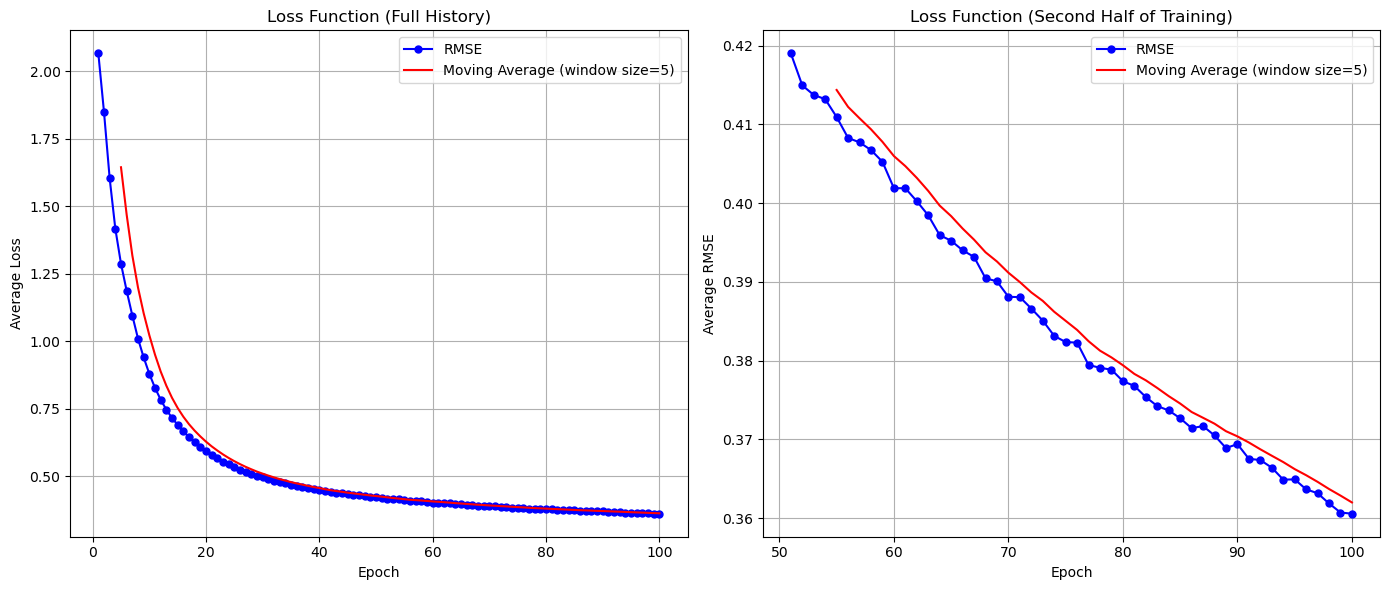

In [12]:
model_nn.plot_training_history()

## Предсказание и сохранение модели после обучения

In [13]:
model_nn.evaluate()

Evaluation RMSE: 0.097636


0.097636394

In [14]:
# model_nn.save_model_pt()

## Демонстрация

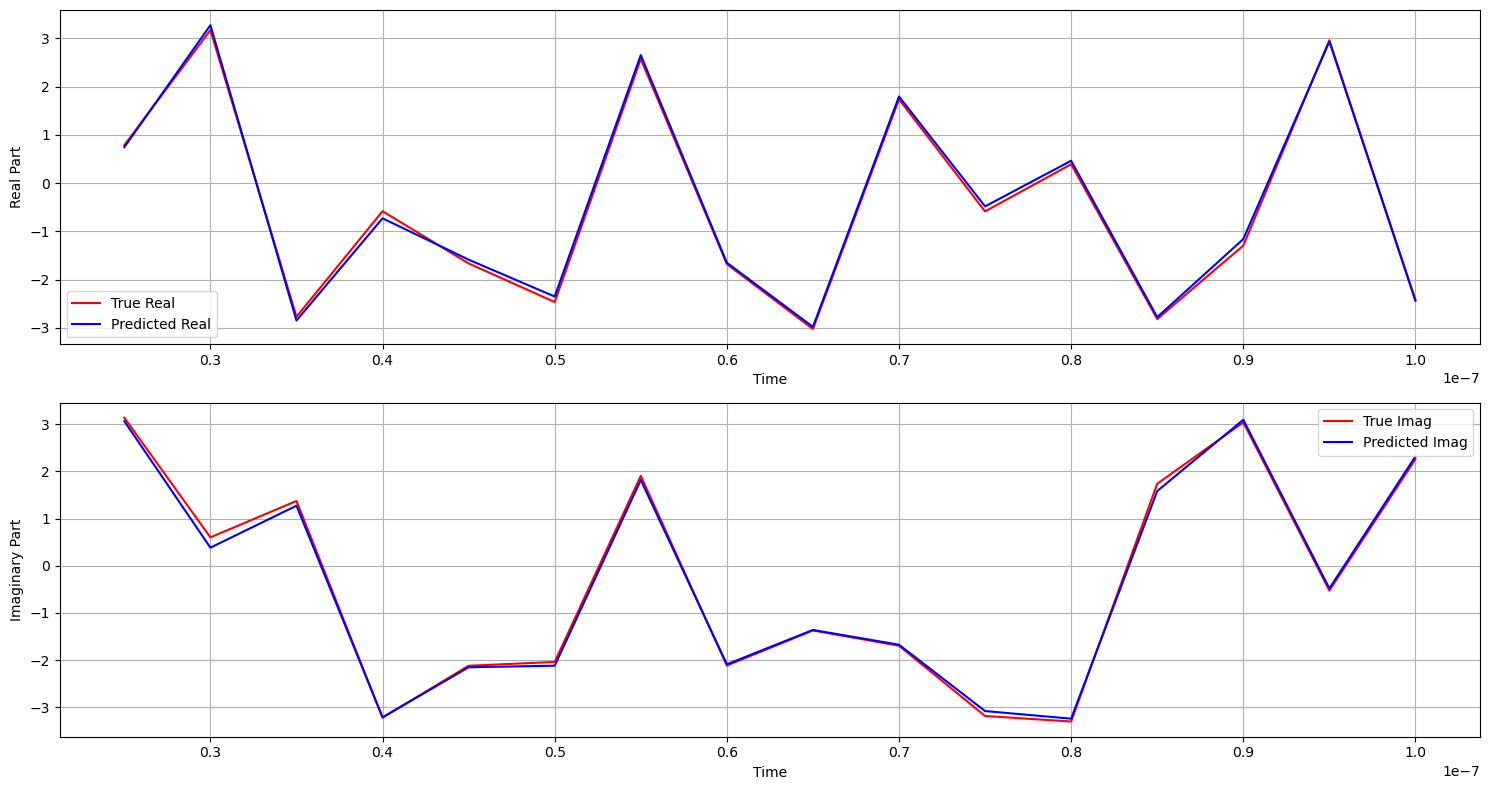

In [15]:
model_nn.plot_predictions(time_start=0, time_end=1e-7)

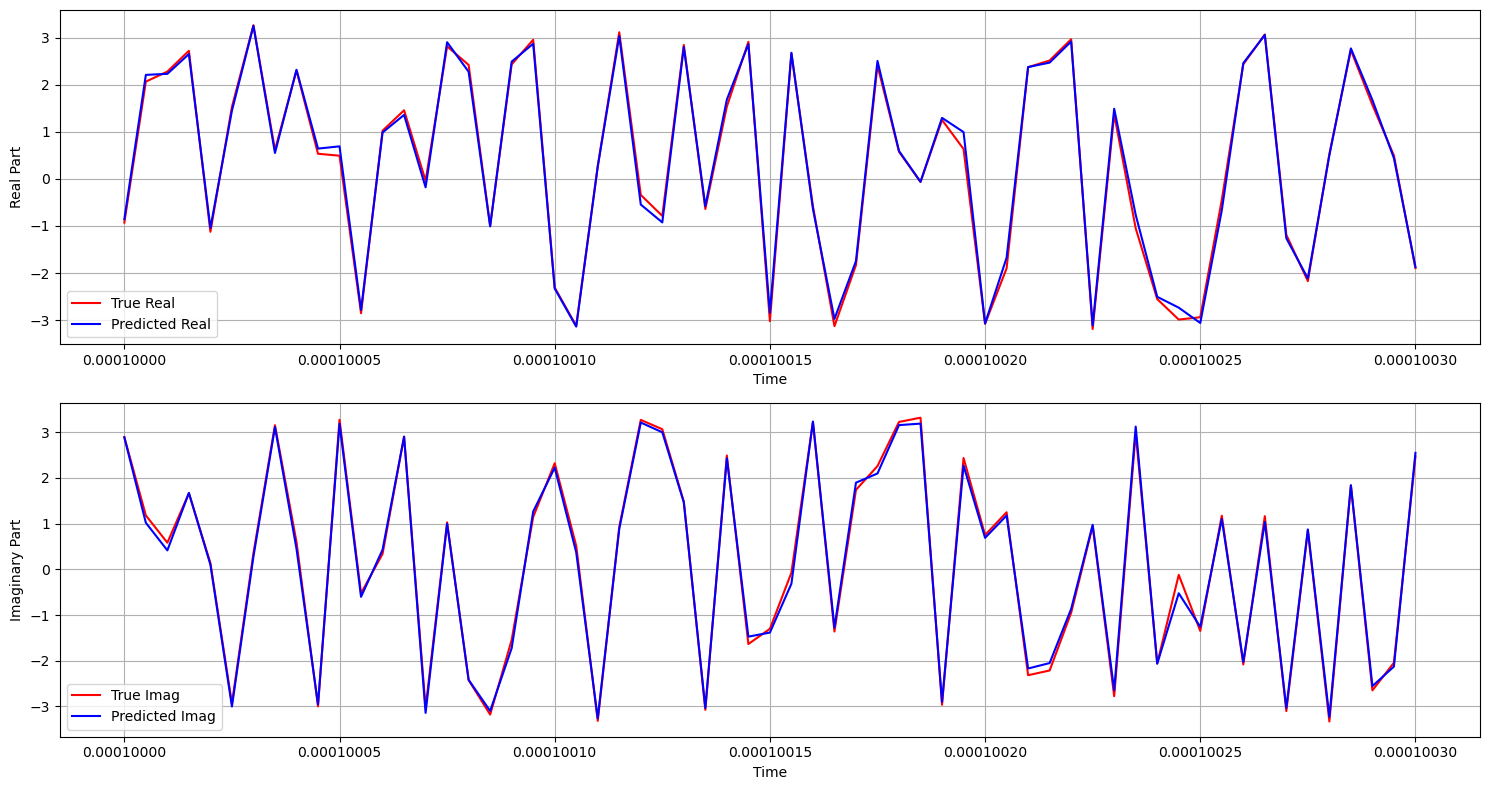

In [16]:
model_nn.plot_predictions(time_start=1e-4, time_end=1.003e-4)

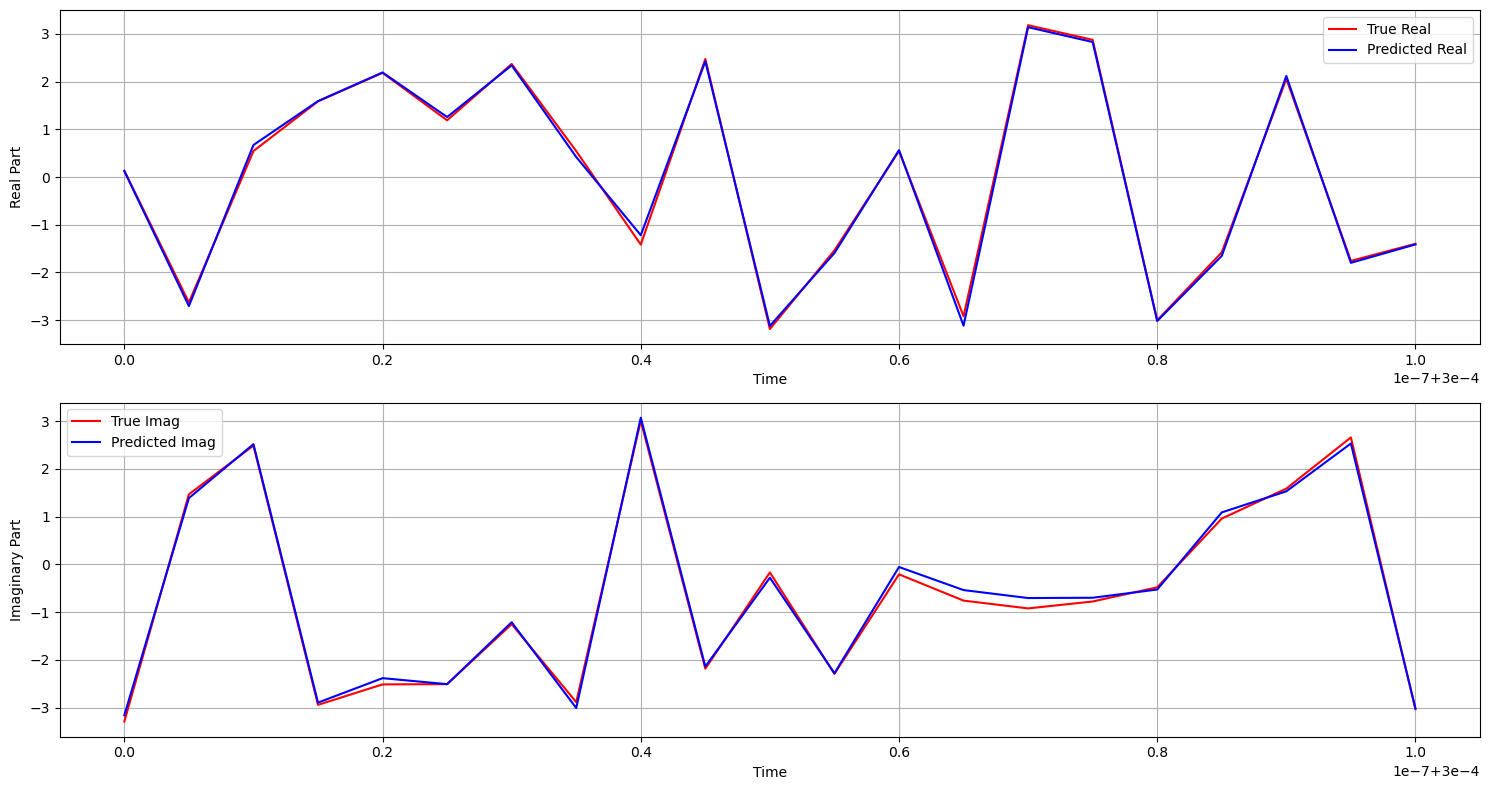

In [17]:
model_nn.plot_predictions(time_start=3e-4, time_end=3.001e-4)

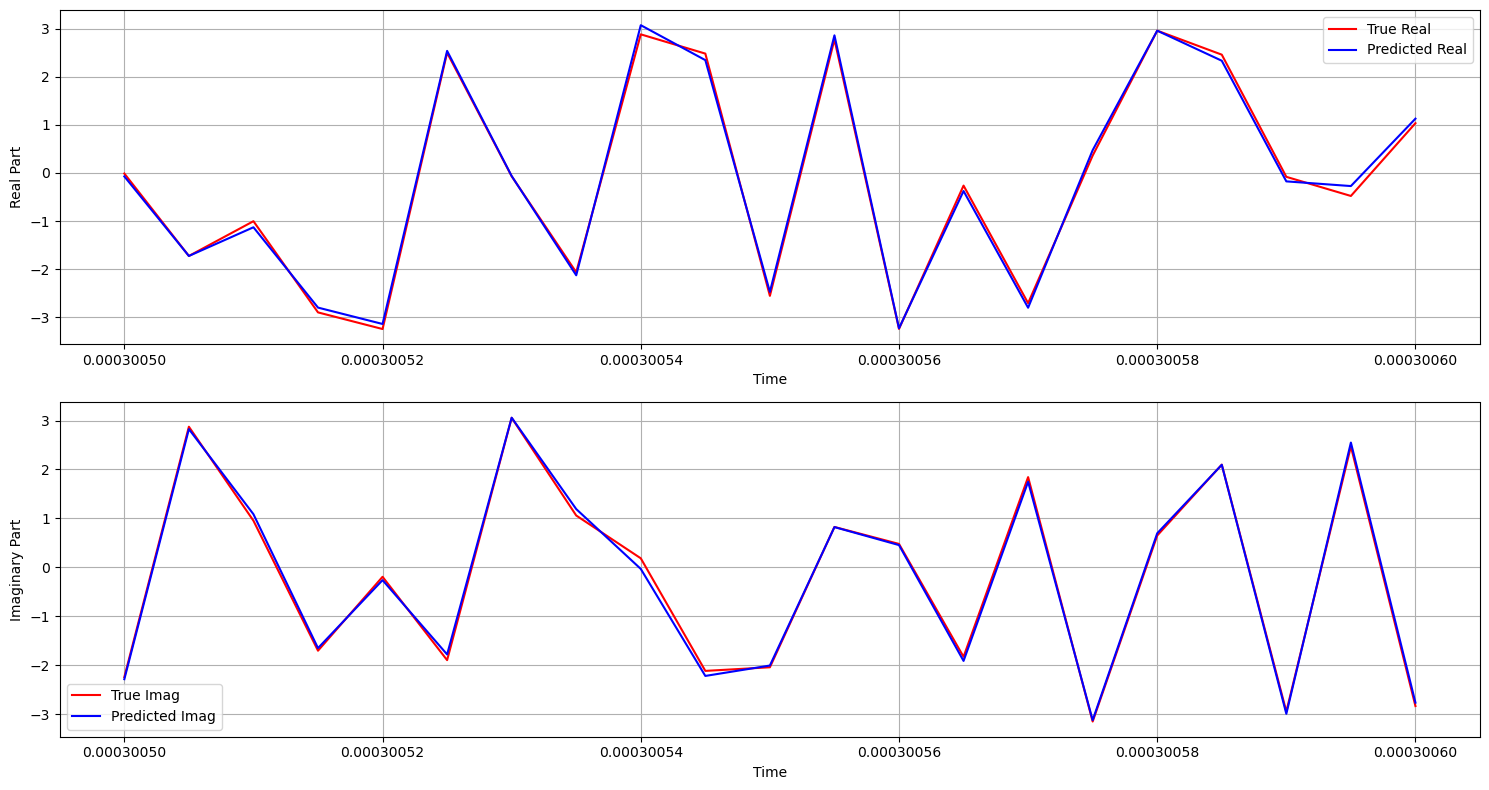

In [18]:
model_nn.plot_predictions(time_start=3.005e-4, time_end=3.006e-4)